# Erisoglu 2011 "New" Algorithm

See: [A new algorithm for initial cluster centers in k-means algorithm](https://www.sciencedirect.com/science/article/pii/S0167865511002248)

## Initial setup and configuration

In [1]:
import imports
import numpy as np
import sklearn.datasets as skdatasets
import sklearn.metrics as skmetrics 
from metrics import accuracy
from matplotlib import pyplot as plt
import kmeans
from initialisations import erisoglu as erisoglu

In [2]:
dataset = skdatasets.load_iris()
data = dataset.data
target = dataset.target

K = 3

eris = erisoglu.Erisoglu(data, K)


## Attempts to reproduce results

### Some descriptive statistics (Table 1)

In [3]:
for i in range(0, len(dataset.feature_names)):
    
    mean = np.mean(dataset.data.T[i])
    stddev = np.std(dataset.data.T[i])
    cvj = eris.variation_coefficient(dataset.data.T[i])
    
    print('%s: mean=%f, stdddev=%f, cvj=%f, ' % (dataset.feature_names[i], mean, stddev, cvj))
    

sepal length (cm): mean=5.843333, stdddev=0.825301, cvj=0.825301, 
sepal width (cm): mean=3.057333, stdddev=0.434411, cvj=0.434411, 
petal length (cm): mean=3.758000, stdddev=1.759404, cvj=1.759404, 
petal width (cm): mean=1.199333, stdddev=0.759693, cvj=0.759693, 


**TODO:** why is standard deviation slightly different?

### Correlations with other features (Table 2)

In [4]:
for i in [0,1,2]:
    
    corr = eris.correlation_coefficient(data.T[3], data.T[i])
    
    print('%s:\t%f' % (dataset.feature_names[i], corr))

sepal length (cm):	0.817941
sepal width (cm):	-0.366126
petal length (cm):	0.962865


**NOTE:** these match the paper exactly as long as we amend the correlation coefficient to Pearson's.

### Paper selects petal width, sepal width as main, secondary:

In [5]:
main = eris._find_main_axis(data.T)
secondary = eris._find_secondary_axis(data.T, main)

print("Main feature deemed to be: %s" % (dataset.feature_names[main]))
print("Secondary feature deemed to be: %s" % (dataset.feature_names[secondary]))

Main feature deemed to be: petal length (cm)
Secondary feature deemed to be: sepal width (cm)


### Paper selects *m* = [1.993, 3.0573]

In [6]:
initial, axes = eris._initialise()
center = eris._find_center(data.T, axes)

print("Center was:", center)
print("Initial seed is:", initial)

Center was: [3.7580000000000005, 3.0573333333333337]
Initial seed is: 118


### Find candidates (c1...K)

In [7]:
c = eris._generate_candidates(initial, axes)

print(c)

[[7.7 2.6 6.9 2.3]
 [4.6 3.6 1.  0.2]
 [4.5 2.3 1.3 0.3]]


Which match the graph and distances in the paper:

![alt text](ss1.png "Logo Title Text 1")



### Try to replicate means of initial clusters (M1...K)

Paper gives (with order corrected):

    m1 = [5.1774, 3.6516, 1.4903, 0.2677]  
    m2 = [6.4024, 2.9506, 5.1193, 1.7916]  
    m3 = [5.1278, 2.7917, 2.5722, 0.6361]

In [8]:
M = eris.find_centers()

print(M)

[[6.40952381 2.9452381  5.13333333 1.77738095]
 [5.04318182 3.50454545 1.46818182 0.25      ]
 [5.28181818 2.59090909 3.08636364 0.89090909]]


## Run k-means

In [9]:
result = kmeans.cluster(data, K, M.copy())

print(result['labels'])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]


### Metrics

In [10]:
ari = skmetrics.adjusted_rand_score(target, result['labels'])
print("Adjusted Rand Index:", ari)

print("Accuracy score:", accuracy.score(target, result['labels']))

Adjusted Rand Index: 0.7163421126838475
Accuracy score: 0.8866666666666667


**NOTE:** paper uses Rand Index, which doesn't seem to be offered in eg. sklearn.

## Graphs 

### Fig. 4a

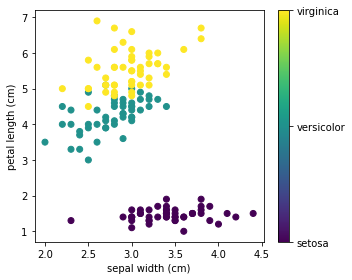

In [11]:
formatter = plt.FuncFormatter(lambda i, *args: dataset.target_names[int(i)])

plt.figure(figsize=(5, 4))

# nb. The paper plots them in a counter-intuitive fashion
plt.scatter(data[:, axes.secondary], data[:, axes.main], c=target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(dataset.feature_names[axes.secondary])
plt.ylabel(dataset.feature_names[axes.main])

plt.tight_layout()
plt.show()